In [1]:
import logging
import os
import re
import time
from pathlib import Path

import bert_score
import matplotlib.pyplot as plt
import nest_asyncio
import pandas as pd
import seaborn as sns
import textstat
from io_functions import get_ollama_version, load_if_scraped, popen, run
from llm_parser import DeepSeekAPI
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from tqdm.notebook import tqdm

In [2]:
logging.basicConfig(level=logging.INFO, force=True)

In [3]:
ollama_server_process = popen('ollama serve')

ollama_server_process

<Popen: returncode: None args: ['ollama', 'serve']>

In [4]:
get_ollama_version()

'ollama version is 0.5.13'

In [5]:
process = run('ollama list')

print(process.stdout)

NAME               ID              SIZE      MODIFIED       
deepseek-r1:70b    0c1615a8ca32    42 GB     38 minutes ago    
deepseek-r1:32b    38056bbcbb2d    19 GB     4 hours ago       
deepseek-r1:8b     28f8fd6cdc67    4.9 GB    4 days ago        



In [6]:
models = [line.strip() for line in process.stdout.split('\n') if line != ''][1:]

model_list = [model.split()[0] for model in models]
model_list

['deepseek-r1:70b', 'deepseek-r1:32b', 'deepseek-r1:8b']

To prevent running a non-existing model:

In [7]:
model_name = model_list[0]
model_name

'deepseek-r1:70b'

In [8]:
model_name = 'deepseek-r1:70b'

In [9]:
if model_name not in model_list:
    run(f'ollama pull {model_name}')

In [10]:
print(run(f'ollama show {model_name}').stdout)

  Model
    architecture        llama     
    parameters          70.6B     
    context length      131072    
    embedding length    8192      
    quantization        Q4_K_M    

  Parameters
    stop    "<｜begin▁of▁sentence｜>"    
    stop    "<｜end▁of▁sentence｜>"      
    stop    "<｜User｜>"                 
    stop    "<｜Assistant｜>"            

  License
    MIT License                    
    Copyright (c) 2023 DeepSeek    




In [11]:
def extract_model_info(text: str):
    embedding_match = re.search(r'embedding length\s+(\d+)', text)
    context_match = re.search(r'context length\s+(\d+)', text)

    embedding_length = int(embedding_match.group(1)) if embedding_match else None
    context_length = int(context_match.group(1)) if context_match else None

    return {'embedding_length': embedding_length, 'context_length': context_length}


model_info = extract_model_info(run(f'ollama show {model_name}').stdout)
model_info

{'embedding_length': 8192, 'context_length': 131072}

In [12]:
print(run('ollama ps').stdout)

NAME               ID              SIZE     PROCESSOR    UNTIL              
deepseek-r1:70b    0c1615a8ca32    46 GB    100% GPU     4 minutes from now    



In [13]:
company_id = '312932093'

In [14]:
df = load_if_scraped(company_id=company_id)

print(df.shape)
df.head()

INFO:root:successfully loaded local transcripts


(2, 9)


,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,312932093,Google LLC,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,12407,14475
1,312932093,Google LLC,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and...",123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,10078,11800


In [15]:
api = DeepSeekAPI(model_name=model_name)

print(api)

DeepSeekAPI(model_name=deepseek-r1:70b, url=http://localhost:11434/api/generate, stream=False, timeout=30, max_retries=3)


In [16]:
nest_asyncio.apply()


async def batch_summary_generation(api: DeepSeekAPI, texts) -> list[str]:
    summaries = []
    times = []

    for text in tqdm(texts):
        prompt = 'summarize: ' + text

        start_time = time.time()
        summary = await api.generate(prompt=prompt)
        end_time = time.time()
        summaries.append(summary)
        times.append(end_time - start_time)
    return summaries, times


summaries, times = await batch_summary_generation(api, df.full_text)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Response received from model deepseek-r1:70b
INFO:root:Response received from model deepseek-r1:70b


In [17]:
print(summaries[0])

The speaker uses a kitchen analogy to explain how machine learning (ML) can be applied through Google Cloud Platform, emphasizing accessibility and creativity over technical complexity. They compare building ML models to using a microwave—most people don’t need to build one to benefit from it. The talk highlights three key tools: AutoML for simplifying model creation, AI Platform for more advanced needs, and TensorFlow for experts. Real-world examples illustrate versatility across industries, such as agriculture, manufacturing, and finance. The importance of open-source solutions and avoiding vendor lock-in is stressed, with Google and Red Hat providing a flexible, future-proof platform. Encouraging experimentation, the speaker invites attendees to explore ML tools without needing deep expertise, emphasizing that creativity and problem-solving are key to getting started.


In [18]:
summary_column = f'{model_name}-summaries'
df[summary_column] = summaries
df['time_spent'] = times

In [19]:
def evaluate_summary(row, model_name, type='baseline'):
    text_to_summarize = row.full_text
    summary = row[summary_column]
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)

    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]

    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    P, R, F1 = bert_score.score(
        [summary], [text_to_summarize], rescale_with_baseline=True, lang='en'
    )

    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0

    readability = textstat.flesch_reading_ease(summary)

    results = {}
    results['model_name'] = model_name
    results['uuid'] = uuid
    results['companyid'] = company_id
    results['companyname'] = company_name
    results['time_spent'] = row.time_spent

    for metric, scores in rouge_scores.items():
        results[f'{metric}_r'] = scores['r']
        results[f'{metric}_p'] = scores['p']
        results[f'{metric}_f'] = scores['f']

    results['bleu'] = bleu_score
    results['bert_precision'] = P.item()
    results['bert_recall'] = R.item()
    results['bert_f1'] = F1.item()
    results['compression_ratio'] = compression_ratio
    results['readability'] = readability

    return pd.DataFrame([results])

In [20]:
evaluation_results = pd.DataFrame()

for _, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat([evaluation_results, evaluation_result], ignore_index=True)

evaluation_results.head()

0it [00:00, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,model_name,uuid,companyid,companyname,time_spent,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,deepseek-r1:70b,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,16.380422,0.051308,0.504950,0.093151,0.003628,0.081967,0.006949,0.049296,0.485149,0.089498,2.093984e-45,-0.016906,-0.238641,-0.128500,0.009914,16.83
1,deepseek-r1:70b,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,28.525689,0.083544,0.668919,0.148537,0.013358,0.234742,0.025278,0.079325,0.635135,0.141035,1.316926e-20,-0.032611,-0.346801,-0.192974,0.022425,23.16


In [21]:
csv_filename = Path('..') / 'data' / 'evaluation_results.csv'

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if ((existing_df.model_name == model_name) & (existing_df.companyid == company_id)).any():
        logging.info(
            f'model {model_name} and {company_id} '
            f'combination already exists in {csv_filename}. '
            f'no new row added.'
        )
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(f'model {model_name} not found. appending new row to {csv_filename}.')
else:
    updated_df = evaluation_results
    logging.info(f'{csv_filename} not found. creating new file.')

updated_df.to_csv(csv_filename, index=False)
logging.info(f'results saved to {csv_filename}')

INFO:root:model deepseek-r1:70b not found. appending new row to ../data/evaluation_results.csv.
INFO:root:results saved to ../data/evaluation_results.csv


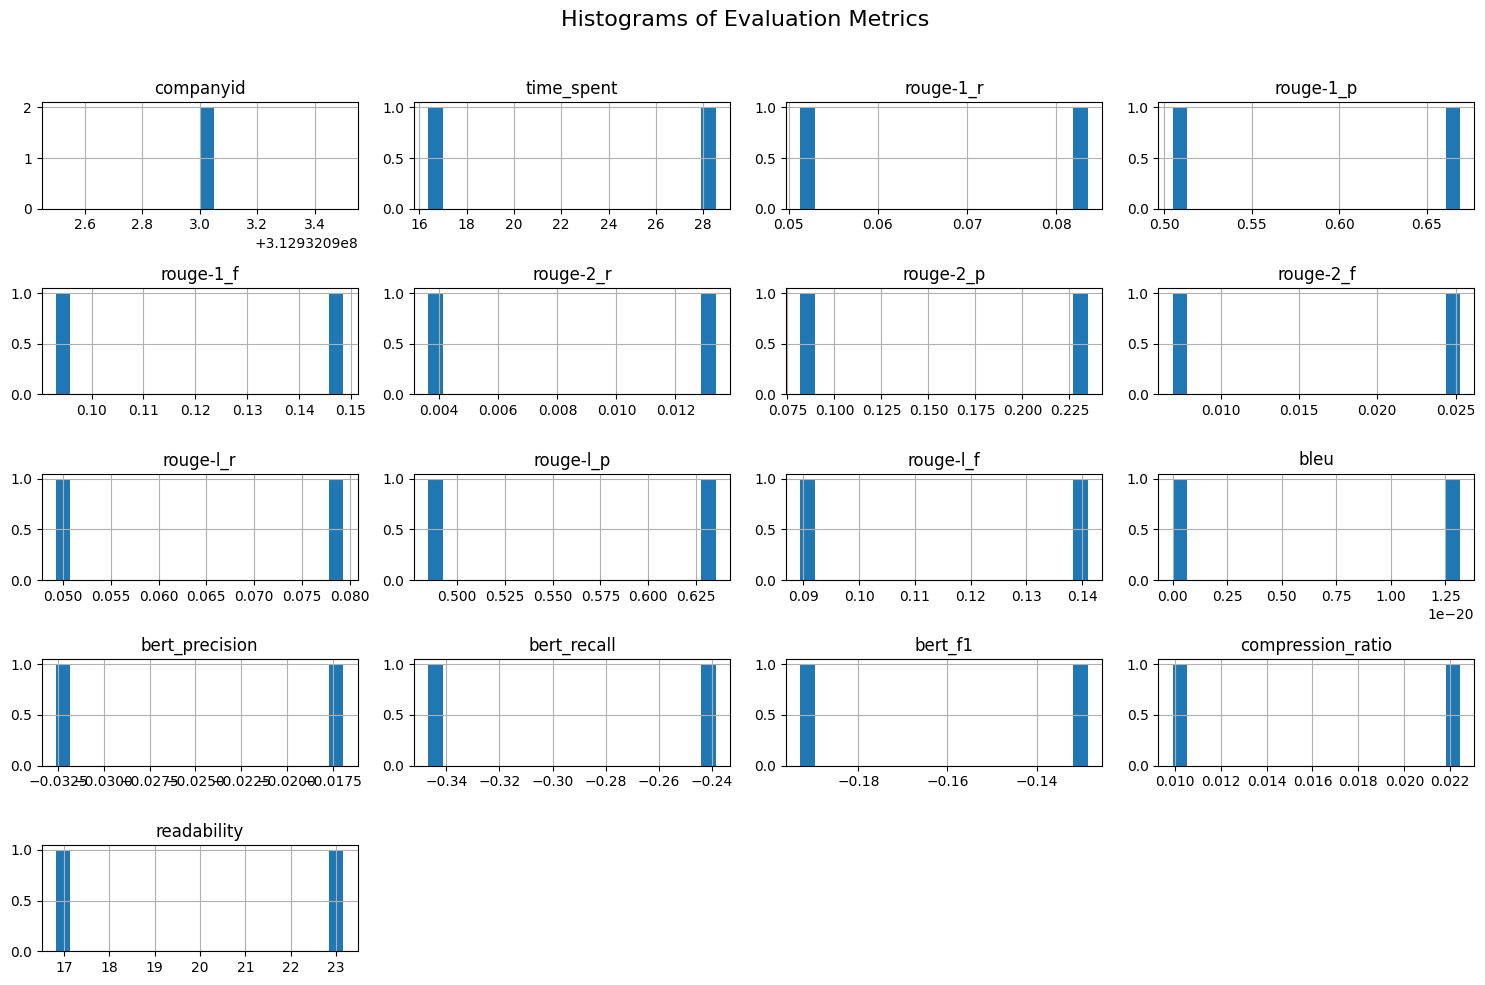

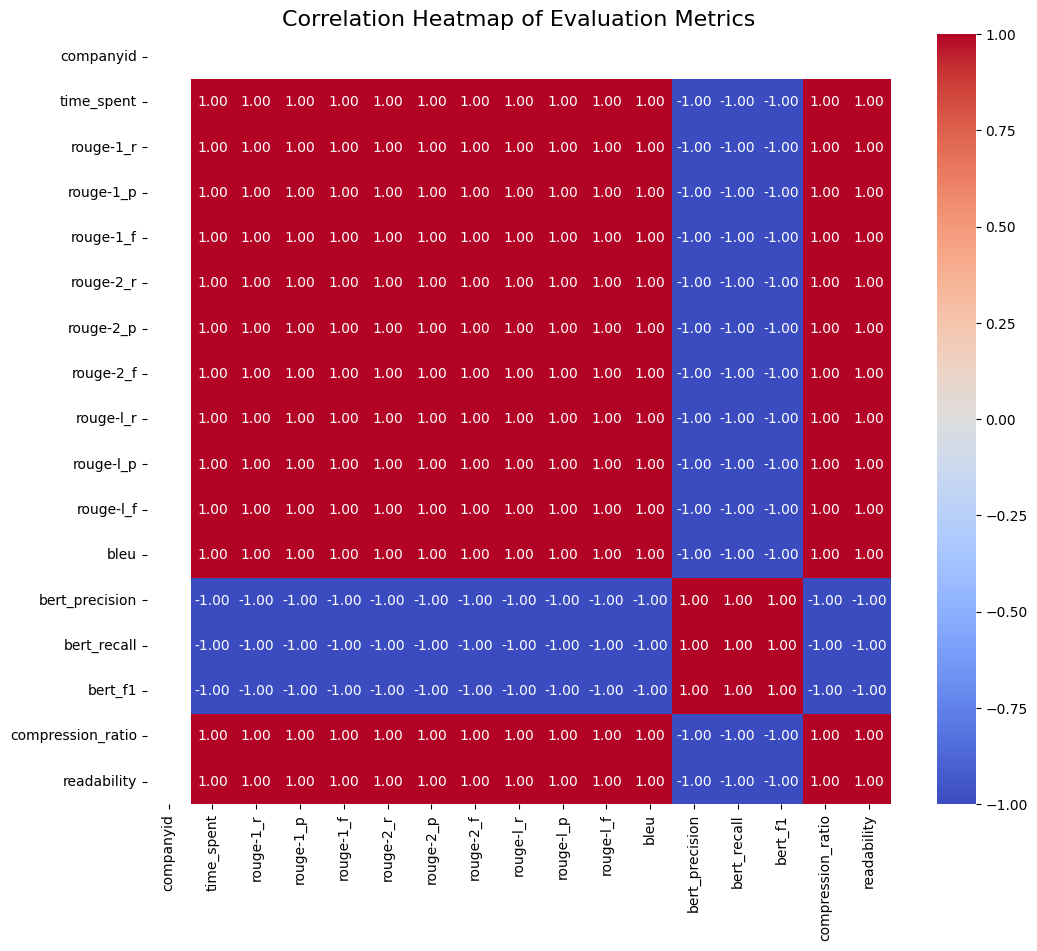

In [22]:
def visualize_results(df):
    '''
    Visualizes evaluation metrics stored in a DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.

    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    '''
    numeric_cols = df.select_dtypes(include='number').columns.tolist()

    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle('Histograms of Evaluation Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Evaluation Metrics', fontsize=16)
    plt.show()


visualize_results(evaluation_results)

In [23]:
df.to_csv(
    Path('..') / 'data' / 'summaries' / f'{company_id}_{model_name}.csv'.replace('/', '-'),
    sep='\t',
    index=False,
    quoting=1,
    escapechar='\\',
    doublequote=True,
    quotechar='"',
    lineterminator='\n',
)

In [24]:
print(df.full_text[0][:2000])

Attendees: Now if there's a company that understands these changes, including machine learning and big data, as well as open source and collaboration, it's Google. You saw one of Google's open source projects, TensorFlow, in today's demo. Just a few minutes, Google Chief Decision Scientist will be here. But before she gives you more information about what intelligent apps will really look like, we'll hear from a shared customer, Kohl's, about their journey with Red Hat and Google. So please welcome Ritch from Kohl's and Cassie from Google.
Attendees: All right. Most of you know Kohl's as a chain of leading American department stores, but you might not know that there's also been a long-time customer of Red Hat. Ritch, could you tell a little bit about Kohl's and your relationship with us?
Attendees: Sure thing. So first of all, it's great to be here. I was really looking forward to summit this year, and then I saw Weezer was playing, and that put me right over the top, icing on the cak

In [25]:
print(df[summary_column][0])

The speaker uses a kitchen analogy to explain how machine learning (ML) can be applied through Google Cloud Platform, emphasizing accessibility and creativity over technical complexity. They compare building ML models to using a microwave—most people don’t need to build one to benefit from it. The talk highlights three key tools: AutoML for simplifying model creation, AI Platform for more advanced needs, and TensorFlow for experts. Real-world examples illustrate versatility across industries, such as agriculture, manufacturing, and finance. The importance of open-source solutions and avoiding vendor lock-in is stressed, with Google and Red Hat providing a flexible, future-proof platform. Encouraging experimentation, the speaker invites attendees to explore ML tools without needing deep expertise, emphasizing that creativity and problem-solving are key to getting started.


In [26]:
ollama_server_process.terminate()